In [0]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
import numpy as np
import cv2 
import os
import glob
from keras.models import Sequential, Model, load_model
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import losses, metrics, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score
from skimage.transform import resize, rescale
from skimage.io import imread
from matplotlib import pyplot as plt
import pickle
import pandas as pd
from sklearn.utils import class_weight

%matplotlib inline

In [76]:
#loading the pre-processed dataset via mounting google drive locally
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#load the dataset into the environment

with open('gdrive/My Drive/dataset_isic_2/X_clf', 'rb') as f:
    X = pickle.load(f)
    
with open('gdrive/My Drive/dataset_isic_2/Y_clf', 'rb') as f:
    y = pickle.load(f)

In [0]:
#train val test split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [92]:
type(X_train)

list

In [164]:
#CNN starts here
model = Sequential()
CNN_input_size = [64, 64, 3]
model.add(Conv2D(32, (3, 3), input_shape = CNN_input_size, activation = 'relu', padding = 'same', name = 'conv1'))
model.add(MaxPooling2D((2, 2), strides = (2, 2)))
model.add(Conv2D(32, (3, 3), input_shape = CNN_input_size, activation = 'relu', padding = 'same', name = 'conv2'))
model.add(MaxPooling2D((2, 2), strides = (2, 2)))
model.add(Conv2D(32, (3, 3), input_shape = CNN_input_size, activation = 'relu', padding = 'same', name = 'conv3'))
model.add(MaxPooling2D((2, 2), strides = (2, 2)))
model.add(Conv2D(32, (3, 3), input_shape = CNN_input_size, activation = 'relu', padding = 'same', name = 'conv4'))
model.add(MaxPooling2D((2, 2), strides = (2, 2)))
model.add(Flatten())

model.add(Dense(128, activation = 'relu', name = 'dense_1'))
model.add(Dense(1, name = 'dense_2'))
model.add(Dropout(0.5))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv4 (Conv2D)               (None, 8, 8, 32)          9248      
__________

In [0]:
#compute class weight as imbalanced dataset
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
model_checkpoint = ModelCheckpoint('./basic_conv.hdf5',save_best_only=True, monitor='val_loss', verbose=2)
tb = TensorBoard(log_dir='./Graph/basic_conv/')

In [166]:
class_weights

array([0.62, 2.64])

In [167]:
#fit the model
history = model.fit(np.array(X_train), np.array(y_train), epochs=20, batch_size=32, validation_data = (np.array(X_val), np.array(y_val)), callbacks=[model_checkpoint,tb], class_weight=class_weights)

Train on 1280 samples, validate on 320 samples
Epoch 1/20
1280/1280 [==============================] - 8s 6ms/step - loss: 0.6217 - acc: 0.8117 - val_loss: 0.5230 - val_acc: 0.8406

Epoch 00001: val_loss improved from inf to 0.52305, saving model to ./basic_conv.hdf5
Epoch 2/20
1280/1280 [==============================] - 7s 6ms/step - loss: 0.5971 - acc: 0.8109 - val_loss: 0.4779 - val_acc: 0.8406

Epoch 00002: val_loss improved from 0.52305 to 0.47790, saving model to ./basic_conv.hdf5
Epoch 3/20
1280/1280 [==============================] - 7s 6ms/step - loss: 0.5885 - acc: 0.8109 - val_loss: 0.4985 - val_acc: 0.8406

Epoch 00003: val_loss did not improve from 0.47790
Epoch 4/20
1280/1280 [==============================] - 7s 6ms/step - loss: 0.5789 - acc: 0.8109 - val_loss: 0.4735 - val_acc: 0.8406

Epoch 00004: val_loss improved from 0.47790 to 0.47345, saving model to ./basic_conv.hdf5
Epoch 5/20
1280/1280 [==============================] - 7s 6ms/step - loss: 0.5778 - acc: 0.8109

In [168]:
#predict on test set
model = load_model('./basic_conv.hdf5')
y_pred = model.predict(np.array(X_test),verbose=1)

400/400 [==============================] - 2s 4ms/step


In [169]:
y_pred

array([[0.47],
       [0.35],
       [0.18],
       [0.32],
       [0.32],
       [0.19],
       [0.3 ],
       [0.32],
       [0.23],
       [0.23],
       [0.21],
       [0.16],
       [0.24],
       [0.4 ],
       [0.34],
       [0.22],
       [0.38],
       [0.36],
       [0.14],
       [0.11],
       [0.12],
       [0.22],
       [0.1 ],
       [0.12],
       [0.37],
       [0.25],
       [0.32],
       [0.16],
       [0.19],
       [0.41],
       [0.34],
       [0.17],
       [0.16],
       [0.41],
       [0.26],
       [0.31],
       [0.05],
       [0.38],
       [0.21],
       [0.44],
       [0.28],
       [0.2 ],
       [0.11],
       [0.19],
       [0.57],
       [0.19],
       [0.23],
       [0.37],
       [0.57],
       [0.12],
       [0.32],
       [0.24],
       [0.37],
       [0.2 ],
       [0.18],
       [0.09],
       [0.35],
       [0.46],
       [0.11],
       [0.06],
       [0.46],
       [0.52],
       [0.44],
       [0.27],
       [0.2 ],
       [0.2 ],
       [0.

In [170]:
y_pred_class = y_pred > 0.5
print ("Precision Score %f",precision_score(y_test, y_pred_class, average='binary'))

Precision Score %f 0.3333333333333333


In [171]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_class, average = None)
f1

array([0.88, 0.1 ])

In [0]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[309  10]
 [ 76   5]]
Normalized confusion matrix
[[0.97 0.03]
 [0.94 0.06]]


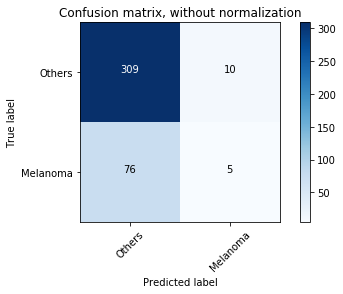

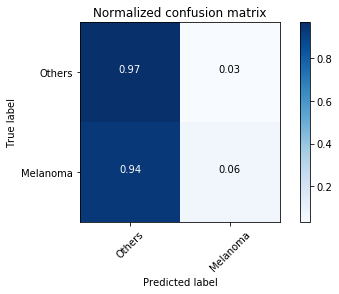

In [173]:
class_names = ["Others","Melanoma"]
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()